In [1]:
from src import *
from src.AFSC import *
import matplotlib.pyplot as plt 
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, fowlkes_mallows_score,silhouette_score,davies_bouldin_score
import pickle
from anndata import AnnData

/home/hanr/anaconda3/envs/CCST2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--checkpoint", default=1, help="1 represents using the trained model.")
parser.add_argument("--k", default=10, help="The number of neighbors. Default is 50")
parser.add_argument("--threshold", default=50, help="The threshold of neighbors. Default is 500")
parser.add_argument("--pca_dim", default=100, help="The dim of pca. Default is 1000")

parser.add_argument("--layers", nargs='?', default='[256]', help="The number of units of each layer of the GNN. Default is [256]")
parser.add_argument("--pred_hid", type=int, default=512, help="The number of hidden units of layer of the predictor. Default is 512")

parser.add_argument("--topk", type=int, default=50, help="The number of neighbors to search")
parser.add_argument("--clus_num_iters", type=int, default=20)
parser.add_argument("--num_centroids", type=int, default=80, help="The number of centroids for K-means Clustering")
parser.add_argument("--num_kmeans", type=int, default=5, help="The number of K-means Clustering for being robust to randomness")

parser.add_argument("--eval_freq", type=float, default=5, help="The frequency of model evaluation")
parser.add_argument("--mad", type=float, default=0.999, help="Moving Average Decay for Teacher Network")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")    
parser.add_argument("--es", type=int, default=3000, help="Early Stopping Criterion")
parser.add_argument("--device", type=int, default=0)
parser.add_argument("--epochs", type=int, default=500)
parser.add_argument("--dropout", type=float, default=0.0)
args, _=parser.parse_known_args()

In [3]:
df = pd.read_csv('./datasets/single-cell/MERFISH/Moffitt_and_Bambah-Mukku_et_al_merfish_all_cells.csv')

In [4]:
df_slice = df[(df['Animal_ID']==18)&(df['Bregma']==0.11)&(df['Cell_class']!='Ambiguous')]
print(df.shape,df_slice.shape,df_slice.head(1))

(1027848, 170) (4975, 170)                                      Cell_ID  Animal_ID Animal_sex   Behavior  \
545969  462b4baf-6b68-4d73-bcf1-ebd7aa09e28d         18     Female  Parenting   

        Bregma  Centroid_X   Centroid_Y     Cell_class Neuron_cluster_ID  \
545969    0.11  935.427246  2535.858258  Endothelial 1               NaN   

        Ace2  ...      Penk  Scg2  Sln  Sst  Tac1  Tac2   Th       Trh  Ucn3  \
545969   0.0  ...  0.020289   0.0  0.0  0.0   0.0   0.0  0.0  0.010762   0.0   

        Vgf  
545969  0.0  

[1 rows x 170 columns]


In [5]:
X = df_slice.iloc[:,9:]
# print(X)
adata = AnnData(X)
spatial = np.array(df_slice.iloc[:,[5,6]])
label = pd.Categorical(df_slice.iloc[:,7]).codes
print(np.unique(label))
adata.obsm['spatial']=spatial
adata.obsm['label']=label
print(adata)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
AnnData object with n_obs × n_vars = 4975 × 161
    obsm: 'spatial', 'label'


/home/hanr/anaconda3/envs/CCST2/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hanr/anaconda3/envs/CCST2/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
adata = process_adata(adata,args.pca_dim,args.k)

AnnData object with n_obs × n_vars = 4975 × 161
    obs: 'n_counts'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'spatial', 'label', 'X_pca', 'distance', 'adj_k', 'distance_k'


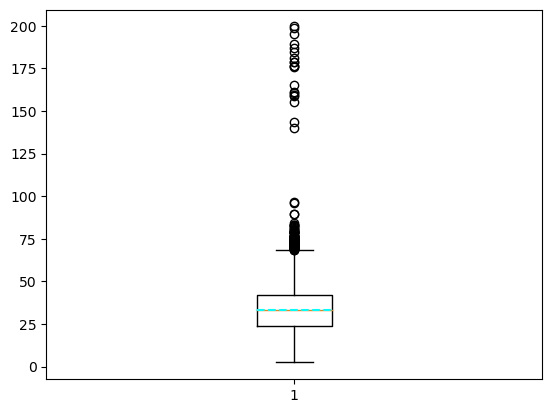

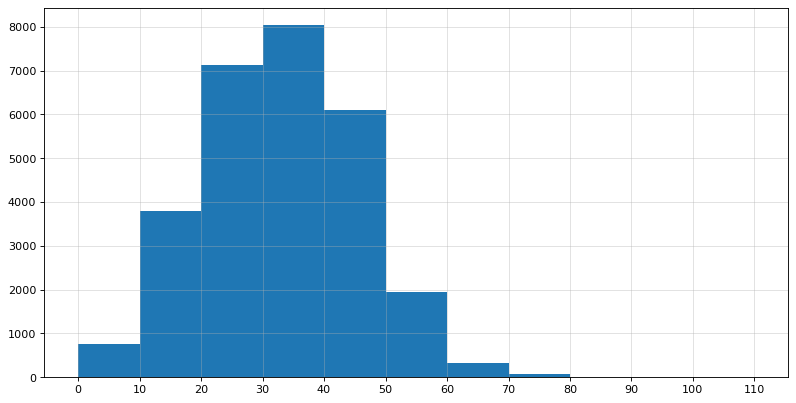

In [7]:
DIS_K=adata.obsm['distance_k']
DIS_K_plot=DIS_K[np.triu_indices(DIS_K.shape[0],k=1)]
DIS_K_plot=DIS_K_plot[DIS_K_plot>0] 
#箱线图
plt.boxplot(DIS_K_plot, showmeans=True, meanline=True,meanprops={'color': 'cyan', 'linewidth': 1.5})
plt.show()
num_bin=[0]
#直方图
i=0
while i<=100:
    i+=10
    num_bin.append(i)
plt.figure(dpi=80,figsize=(12,6))
plt.hist(DIS_K_plot, num_bin)
plt.xticks(num_bin)
plt.grid(alpha=0.4)
plt.show()

In [8]:
def train(adata,threshold):
    data = prepare_data(adata,threshold)
    model_AFSL =cluster()
    #Run
    model_AFSL.train(data,args,n_clusters=15,init_spa=True,res=0.7, tol=5e-3, lr=0.05, max_epochs=500)
    y_pred, x =model_AFSL.predict()
    refined_pred=refine(adata,sample_id=adata.obs.index.tolist(), pred=y_pred.tolist())
    adata.obs["pred"]=refined_pred
    NMI = normalized_mutual_info_score(adata.obsm["label"], adata.obs["pred"], average_method='arithmetic')
    ARI = adjusted_rand_score(adata.obsm["label"], adata.obs["pred"])
    FMI = fowlkes_mallows_score(adata.obsm["label"], adata.obs["pred"]) 
    SC = silhouette_score(x.detach().numpy(), adata.obs["pred"])
    DBI = davies_bouldin_score(x.detach().numpy(), adata.obs["pred"])
    print('===== ARI:{:.2f},NMI:{:.2f},FMI:{:.2f},SC:{:.2f},DBI:{:.2f} ===='.format(ARI,NMI,FMI,SC,DBI))
    label = np.ascontiguousarray(refined_pred) 
    df_label = pd.DataFrame(label,columns=['label'])
    df_label.to_csv('./results/label/MERFISH.csv',index=False)
    np.save(f'./results/feat/MERFISH.npy', x.detach().numpy())
    output_hal = open("./results/model/MERFISH.pkl", 'wb')
    s = pickle.dumps(model_AFSL)
    output_hal.write(s)
    output_hal.close()
    print('save')
    torch.cuda.empty_cache()

In [9]:
def test(adata,checkpoint_path):
    model_AFSL = cluster()
    with open(checkpoint_path,'rb') as file:
        model_AFSL  = pickle.loads(file.read())

    y_pred, x =model_AFSL.predict()
    refined_pred=refine(adata,sample_id=adata.obs.index.tolist(), pred=y_pred.tolist())
    adata.obs["pred"]=refined_pred
    NMI = normalized_mutual_info_score(adata.obsm["label"], adata.obs["pred"], average_method='arithmetic')
    ARI = adjusted_rand_score(adata.obsm["label"], adata.obs["pred"])
    FMI = fowlkes_mallows_score(adata.obsm["label"], adata.obs["pred"]) 
    SC = silhouette_score(x.detach().numpy(), adata.obs["pred"])
    DBI = davies_bouldin_score(x.detach().numpy(), adata.obs["pred"])
    print('===== ARI:{:.2f},NMI:{:.2f},FMI:{:.2f},SC:{:.2f},DBI:{:.2f} ===='.format(ARI,NMI,FMI,SC,DBI))

In [10]:
threshold = args.threshold
if args.checkpoint == 0:
    train(adata,threshold)
else:
    test(adata,'./results/model/MERFISH.pkl')

===== ARI:0.20,NMI:0.23,FMI:0.40,SC:0.20,DBI:1.30 ====
